In [1]:
import sys

In [2]:
#SCC package environment
sys.path.insert(0,'/KIMEL/tigrlab/projects/jjeyachandra/gmsh-sdk/lib/')
sys.path.insert(0,'/projects/jjeyachandra/simnibs/miniconda2/envs/simnibs_env/lib/python2.7/site-packages')
sys.path.insert(0,'/projects/jjeyachandra/simnibs/Python_modules/src')

In [3]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from fieldopt import geolib
import numpy as np
import gmsh

In [4]:
%matplotlib notebook

In [5]:
#Load in subject/target specific files
proj_dir='/projects/jjeyachandra/rtms_optimize'
C = np.fromfile(os.path.join(proj_dir,'output','quadratic_vec'))
iR = np.fromfile(os.path.join(proj_dir,'output','inverse_rot')).reshape(3,3)
b = np.fromfile(os.path.join(proj_dir,'output','param_bounds')).reshape(3,2)

In [6]:
#Make inputs
fidelity = 20
x_samps = np.linspace(b[0,0],b[0,1],fidelity)
y_samps = np.linspace(b[1,0],b[1,1],fidelity)
rot_samps = np.linspace(0,180,fidelity)
XX,YY,RR = np.meshgrid(x_samps,y_samps,rot_samps)
XX_f = XX.flatten().reshape((fidelity**3,1))
YY_f = YY.flatten().reshape((fidelity**3,1))
RR_f = RR.flatten().reshape((fidelity**3,1))
sample_set = np.concatenate((XX_f,YY_f,RR_f),axis=1)

In [7]:
#For each input sample compute the quadratic image and rotational component
preaff_locs=np.zeros_like(sample_set,dtype=np.float64)
preaff_rots=np.zeros_like(sample_set,dtype=np.float64)
normals = np.zeros_like(sample_set,dtype=np.float64)
for i in np.arange(0,sample_set.shape[0]):
    x,y,r = sample_set[i,:]
    preaff_locs[i,:] = geolib.map_param_2_surf(x,y,C)
    preaff_rots[i,:], normals[i,:] = geolib.map_rot_2_surf(x,y,r,C)

In [8]:
#Make plotting variables
pXX = XX[:,:,0]
pYY = YY[:,:,0]

In [9]:
XY_slice = preaff_locs[::fidelity]
pZZ = XY_slice[:,2].reshape((fidelity,fidelity))

In [10]:
def make_scaled_vecs(p,d,s=3):
    '''
    p - Surface point (3d vec)
    d - Direction vector (3d vec)
    s - Scale length factor [default=3]
    '''
    
    return np.c_[p, s*d.T + p]

<IPython.core.display.Javascript object>


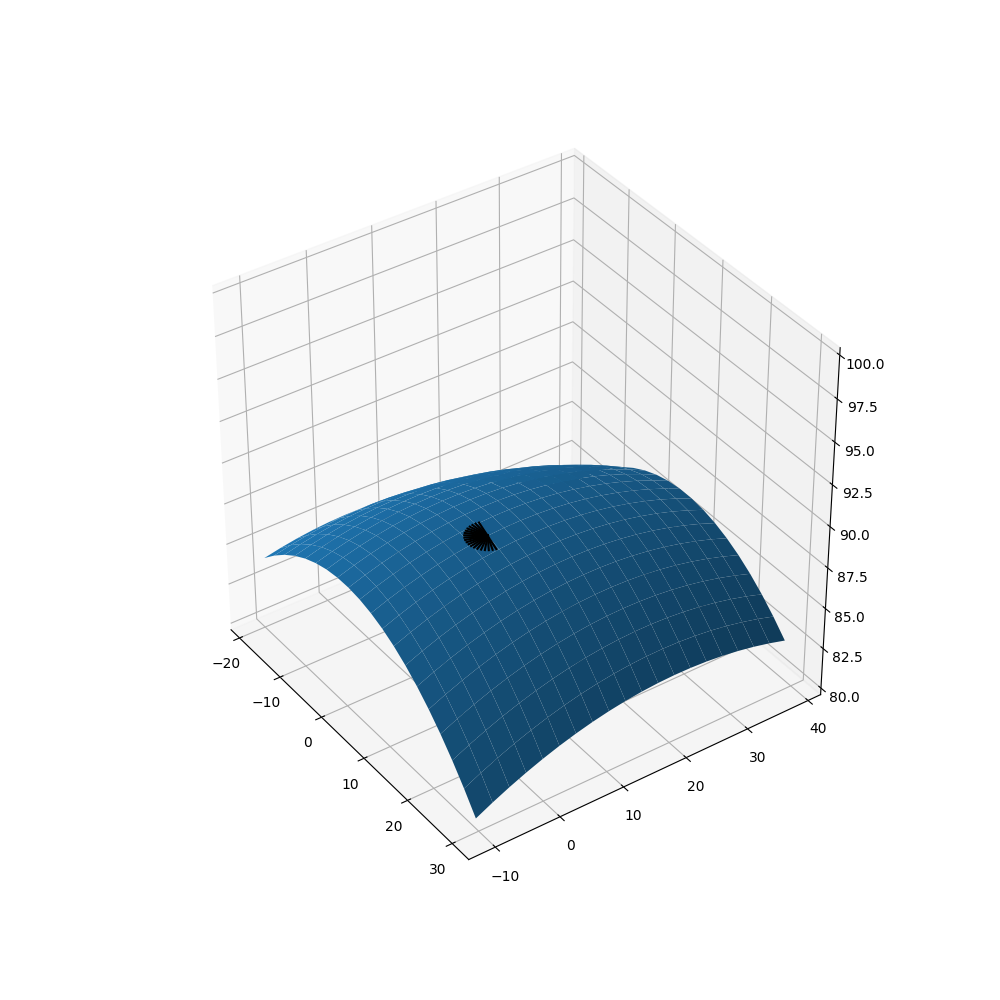

In [11]:
#Make canvas
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

#Plot surface
ax.plot_surface(pXX,pYY,pZZ)
ax.set_zlim(bottom=80, top=100)

#Now view each set of inputs manually, then animate on surface?
ind = 3000
surf_point = preaff_locs[ind]
for i in np.arange(0,fidelity):
    r = make_scaled_vecs(surf_point,preaff_rots[ind + i])
    ax.plot3D(r[0,:],r[1,:],r[2,:],'k')


## DEBUGGING PROCESS

In [12]:
def compute_principal_dir(x,y,C):
    '''
    Compute the principal direction of a quadratic surface of form:
    S: f(x,y) = a + bx + cy + dxy + ex^2 + fy^2
    Using the second fundamental form basis matrix eigendecomposition method

    x -- scalar x input
    y -- scalar y input
    C -- scalar quadratic vector (a,b,c,d,e,f)

    V[:,0] -- major principal direction
    V[:,1] -- minor principal direction
    n      -- normal to surface S at point (x,y)
    '''

    #Compute partial first and second derivatives
    r_x = np.array([1, 0, 2*C[4]*x + C[1] + C[3]*y])
    r_y = np.array([0, 1, 2*C[5]*y + C[2] + C[3]*x])
    r_xx = np.array([0, 0, 2*C[4]])
    r_yy = np.array([0, 0, 2*C[5]])
    r_xy = np.array([0, 0, C[3]])

    #Compute surface point normal
    r_x_cross_y = np.cross(r_x,r_y)
    n = r_x_cross_y/np.linalg.norm(r_x_cross_y)

    #Compute second fundamental form constants
    L = np.dot(r_xx,n)
    M = np.dot(r_xy,n)
    N = np.dot(r_yy,n)

    #Form basis matrix
    P = np.array([
        [L, M],
        [M, N]
    ])

    #Eigendecomposition, then convert into 3D vector
    _,V = np.linalg.eig(P)
    V = np.concatenate((V,np.zeros((1,2))), axis=0)

    return V[:,0], V[:,1], n

def interpolate_angle(u,v,t,l=90.0):
    theta = (t/l)*(np.pi/2)
    p = np.r_[u*np.cos(theta) + v*np.sin(theta), 0] #bug was addition of two cosine components oops
    return p

In [13]:
# First given input vector get principal direction
ind = 3000
x,y,r = preaff_locs[ind]
u,v,n = compute_principal_dir(x,y,C)

<IPython.core.display.Javascript object>


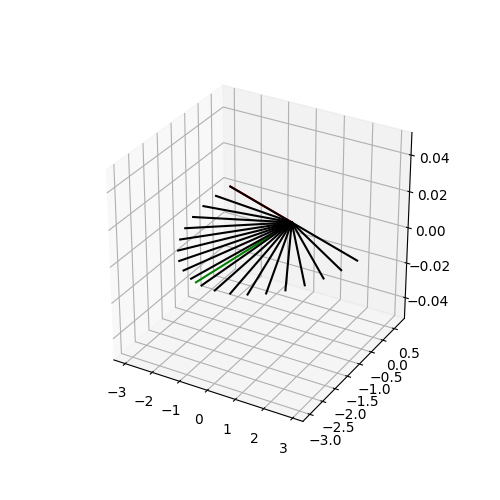

In [14]:
#Now interpolate angle and visualize
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
p1 = make_scaled_vecs(np.array([0,0,0]), u)
p2 = make_scaled_vecs(np.array([0,0,0]), v)

ax.plot3D(p1[0,:],p1[1,:],p1[2,:],'r')
ax.plot3D(p2[0,:],p2[1,:],p2[2,:],'g')
t = np.linspace(0,180,fidelity)
for i in np.arange(0,fidelity):
    r = interpolate_angle(u[:2],v[:2],t[i])
    r = make_scaled_vecs(np.array([0,0,0]), r)
    ax.plot3D(r[0,:],r[1,:],r[2,:],'k')